# Tutorial: Chemical Properties Prediction with Graph Neural Networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial15/tutorial.ipynb)

In this tutorial we will use **Graph Neural Networks** (GNNs) for chemical properties prediction. Chemical properties prediction involves estimating or determining the physical, chemical, or biological characteristics of molecules based on their structure. 

Molecules can naturally be represented as graphs, where atoms serve as the nodes and chemical bonds as the edges connecting them. This graph-based structure makes GNNs a great fit for predicting chemical properties.

In the tutorial we will use the [QM9 dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html#torch_geometric.datasets.QM9) from Pytorch Geometric. The dataset contains small molecules, each consisting of up to 29 atoms, with every atom having a corresponding 3D position. Each atom is also represented by a five-dimensional one-hot encoded vector that indicates the atom type (H, C, N, O, F).

First of all, let's start by importing useful modules!

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import warnings

from pina import Trainer
from pina.solver import SupervisedSolver
from pina.problem.zoo import SupervisedProblem

from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, global_mean_pool

warnings.filterwarnings("ignore")

## Download Data and create the Problem

We download the dataset and save the molecules as a list of `Data` objects (`input_`), where each element contains one molecule encoded in a graph structure. The corresponding target properties (`target_`) are listed below:

| Target | Property                         | Description                                                                       | Unit                                        |
|--------|----------------------------------|-----------------------------------------------------------------------------------|---------------------------------------------|
| 0      | $\mu$                            | Dipole moment                                                                     | $D$                                         |
| 1      | $\alpha$                         | Isotropic polarizability                                                          | $a₀³$                                       |
| 2      | $\epsilon_{\textrm{HOMO}}$       | Highest occupied molecular orbital energy                                         | $eV$                                        |
| 3      | $\epsilon_{\textrm{LUMO}}$       | Lowest unoccupied molecular orbital energy                                        | $eV$                                        |
| 4      | $\Delta \epsilon$                | Gap between $\epsilon_{\textrm{HOMO}}$ and $\epsilon_{\textrm{LUMO}}$             | $eV$                                        |
| 5      | $\langle R^2 \rangle$            | Electronic spatial extent                                                         | $a₀²$                                       |
| 6      | $\textrm{ZPVE}$                  | Zero point vibrational energy                                                     | $eV$                                        |
| 7      | $U_0$                            | Internal energy at 0K                                                             | $eV$                                        |
| 8      | $U$                              | Internal energy at 298.15K                                                        | $eV$                                        |
| 9      | $H$                              | Enthalpy at 298.15K                                                               | $eV$                                        |
| 10     | $G$                              | Free energy at 298.15K                                                            | $eV$                                        |
| 11     | $c_{\textrm{v}}$                 | Heat capacity at 298.15K                                                          | $cal/(mol·K)$                               |
| 12     | $U_0^{\textrm{ATOM}}$            | Atomization energy at 0K                                                          | $eV$                                        |
| 13     | $U^{\textrm{ATOM}}$              | Atomization energy at 298.15K                                                     | $eV$                                        |
| 14     | $H^{\textrm{ATOM}}$              | Atomization enthalpy at 298.15K                                                   | $eV$                                        |
| 15     | $G^{\textrm{ATOM}}$              | Atomization free energy at 298.15K                                                | $eV$                                        |
| 16     | $A$                              | Rotational constant                                                               | $GHz$                                       |
| 17     | $B$                              | Rotational constant                                                               | $GHz$                                       |
| 18     | $C$                              | Rotational constant                                                               | $GHz$                                       |


In [2]:
# download the data + shuffling
dataset = QM9(root="./tutorial_logs").shuffle()

# save the dataset
input_ = [data for data in dataset]
target_ = torch.cat([data.y for data in dataset])

# normalize the target
mean = target_.mean(dim=0, keepdim=True)
std = target_.std(dim=0, keepdim=True)
target_ = (target_ - mean) / std

Great! Once the data are downloaded, building the problem is straightforward by using the [`SupervisedProblem`](https://mathlab.github.io/PINA/_rst/problem/zoo/supervised_problem.html) class.

In [3]:
# build the problem
problem = SupervisedProblem(input_=input_, output_=target_)

## Build the Model

To predict molecular properties, we will construct a simple Convolutional Graph Neural Network using the [`GCNConv`]() module from PyG. While this tutorial focuses on a straightforward model, more advanced architectures—such as Equivariant Networks—could potentially yield better performance. Please note that this tutorial serves only for demonstration purposes.

**Importantly** notice that in the `forward` pass we pass a data object as input, and unpack inside the graph attributes. This is the only requirement in **PINA** to use graphs and solvers together.

In [4]:
class GNN(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden_dim=256):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, out_features)

    def forward(self, data):
        # extract attributes, N.B. in PINA Data object are passed as input
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # perform normal graph operations
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)

## Train the Model

Now that the problem is created and the model is built, we can train the model using the [`SupervisedSolver`](https://mathlab.github.io/PINA/_rst/solver/supervised.html), which is the solver for standard supervised learning task. We will optimize the Maximum Absolute Error and test on the same metric. In the [`Trainer`](https://mathlab.github.io/PINA/_rst/trainer.html) class we specify the optimization hyperparameters.

In [ ]:
# define the solver
solver = SupervisedSolver(
    problem=problem,
    model=GNN(in_features=11, out_features=19),
    use_lt=False,
    loss=torch.nn.L1Loss(),
)
trainer = Trainer(
    solver,
    max_epochs=3,
    train_size=0.7,
    test_size=0.2,
    val_size=0.1,
    batch_size=512,
    accelerator="cpu",
    enable_model_summary=False,
)
trainer.train()

## Testing Chemical Predictions

In [6]:
_ = trainer.test()

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3822993338108063
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


We observe that the model achieves an average error of approximately 0.4 MAE across all property predictions. This error is an average, but we can also inspect the error for each individual property prediction.

To do this, we need access to the test dataset, which can be retrieved from the trainer's datamodule. Each datamodule contains both the dataloader and dataset objects. For the dataset, we can use the [`get_all_data()`](https://mathlab.github.io/PINA/_rst/data/dataset.html#pina.data.dataset.PinaDataset.get_all_data) method. This function returns the entire dataset as a dictionary, where the keys represent the Condition names, and the values are dictionaries containing input and target tensors.

In [7]:
# get the test dataset
test_dataset = trainer.datamodule.test_dataset.get_all_data()
print("Here the dataset")
print(f"Dataset keys: {test_dataset.keys()}")
print(f"Dataset keys for data condition: {test_dataset['data'].keys()}")
print(
    f"Dataset values type for data condition: {[v.__class__.__name__ for v in test_dataset['data'].values()]}"
)

# extract input and target for test dataset
input_test = test_dataset["data"]["input"]
target_test = test_dataset["data"]["target"]

Here the dataset
Dataset keys: dict_keys(['data'])
Dataset keys for data condition: dict_keys(['input', 'target'])
Dataset values type for data condition: ['DataLabelBatch', 'Tensor']


Now we obtain the prediction my calling the forward pass for the `SupervisedSolver`.

In [8]:
# get the prediction
prediction_test = solver(input_test)
print(f"Number of prediction properties: {prediction_test.shape[-1]}")

Number of prediction properties: 19


As you can see we obtain a tensor with 19 prediction properties as output, which is what we are looking for. Now let's compute the error for each property:

In [9]:
properties = [
    "μ",
    "α",
    "ε HOMO",
    "ε LUMO",
    "Δε",
    "⟨R²⟩",
    "ZPVE",
    "U₀",
    "U",
    "H",
    "G",
    "cv",
    "U₀ ATOM",
    "U ATOM",
    "H ATOM",
    "G ATOM",
    "A",
    "B",
    "C",
]

units = [
    "D",
    "a₀³",
    "eV",
    "eV",
    "eV",
    "a₀²",
    "eV",
    "eV",
    "eV",
    "eV",
    "eV",
    "cal/(mol·K)",
    "eV",
    "eV",
    "eV",
    "eV",
    "GHz",
    "GHz",
    "GHz",
]

print(f"{'Property':<10} | {'Error':<8} | {'Unit'}")
print("-" * 34)

for idx in range(19):
    error = torch.abs(prediction_test[:, idx] - target_test[:, idx]).mean()
    print(f"{properties[idx]:<10} | {error:.4f}   | {units[idx]}")

Property   | Error    | Unit
----------------------------------
μ          | 0.6707   | D
α          | 0.4396   | a₀³
ε HOMO     | 0.6580   | eV
ε LUMO     | 0.5939   | eV
Δε         | 0.6532   | eV
⟨R²⟩       | 0.6317   | a₀²
ZPVE       | 0.2255   | eV
U₀         | 0.3306   | eV
U          | 0.3307   | eV
H          | 0.3307   | eV
G          | 0.3316   | eV
cv         | 0.5134   | cal/(mol·K)
U₀ ATOM    | 0.2827   | eV
U ATOM     | 0.2815   | eV
H ATOM     | 0.2810   | eV
G ATOM     | 0.2855   | eV
A          | 0.0045   | GHz
B          | 0.2107   | GHz
C          | 0.2081   | GHz


We can see that predicting the some properties are easier and some harder to predict. For example, the rotational constant $A$ is way easier to predict than dipole moment $\mu$. To have a better idea we can also plot a scatter plot between predicted and observed properties:

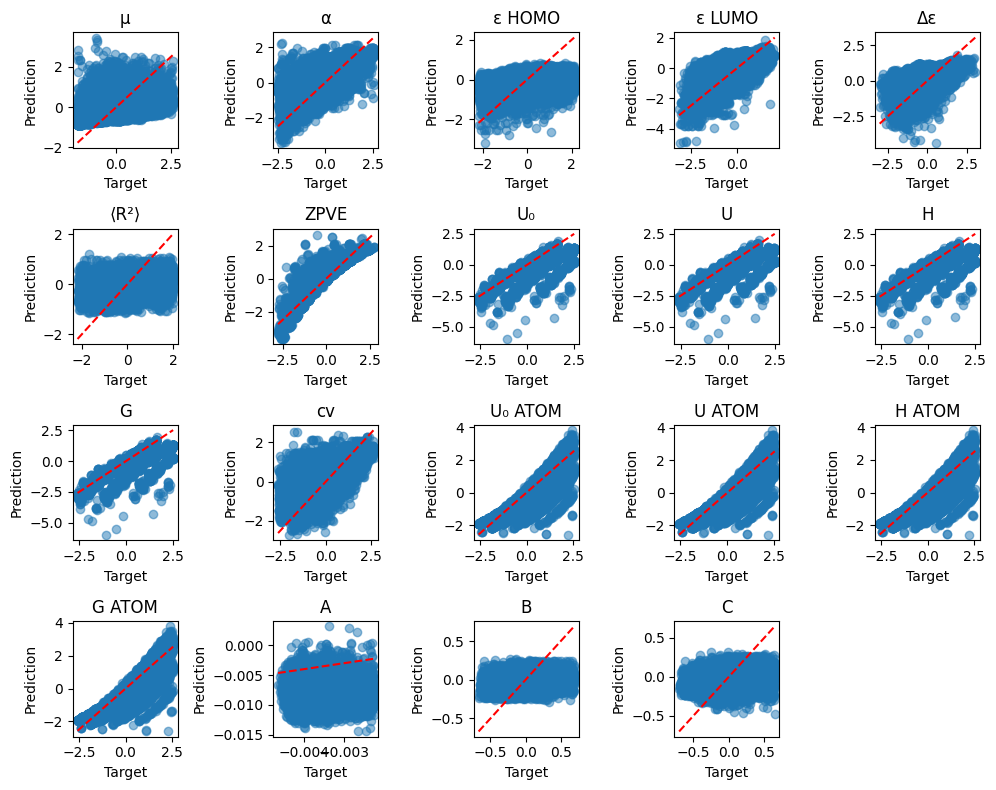

In [10]:
import matplotlib.pyplot as plt

# Set up the plot grid
num_properties = 19
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()

# Outlier removal using IQR (with torch)
for idx in range(num_properties):
    target_vals = target_test[:, idx]
    pred_vals = prediction_test[:, idx]

    # Calculate Q1 (25th percentile) and Q3 (75th percentile) using torch
    Q1 = torch.quantile(target_vals, 0.25)
    Q3 = torch.quantile(target_vals, 0.75)
    IQR = Q3 - Q1

    # Define the outlier range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    mask = (target_vals >= lower_bound) & (target_vals <= upper_bound)
    filtered_target = target_vals[mask]
    filtered_pred = pred_vals[mask]

    # Plotting
    ax = axes[idx]
    ax.scatter(
        filtered_target.detach(),
        filtered_pred.detach(),
        alpha=0.5,
        label="Data points (no outliers)",
    )
    ax.plot(
        [filtered_target.min().item(), filtered_target.max().item()],
        [filtered_target.min().item(), filtered_target.max().item()],
        "r--",
        label="y=x",
    )

    ax.set_title(properties[idx])
    ax.set_xlabel("Target")
    ax.set_ylabel("Prediction")

# Remove the extra subplot (since there are 19 properties, not 20)
if num_properties < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

By looking more into details, we can see that $A$ is not predicted that well, but the small values of the quantity lead to a lower MAE than the other properties. From the plot we can see that the atomatization energies, free energy and enthalpy are the predicted properties with higher correlation with the true chemical properties.

## What's Next?

Congratulations on completing the tutorial on chemical properties prediction with **PINA**! Now that you've got the basics, there are several exciting directions to explore:

1. **Train the network for longer or with different layer sizes**: Experiment with various configurations to see how the network's accuracy improves.

2. **Use a different network**: For example, Equivariant Graph Neural Networks (EGNNs) have shown great results on molecular tasks by leveraging group symmetries. If you're interested, check out [*E(n) Equivariant Graph Neural Networks*](https://arxiv.org/abs/2102.09844) for more details.

3. **What if the input is time-dependent?**: For example, predicting force fields in Molecular Dynamics simulations. In PINA, you can predict force fields with ease, as it's still a supervised learning task. If this interests you, have a look at [*Machine Learning Force Fields*](https://pubs.acs.org/doi/10.1021/acs.chemrev.0c01111).

4. **...and many more!**: The possibilities are vast, including exploring new architectures, working with larger datasets, and applying this framework to more complex systems.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).